Differential expression analysis for Stem cluster between AA and Control groups

In [ ]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata1_test = adata1.copy()
adata1_test.X = np.squeeze(np.asarray(adata1.raw.X))
adata1_test.obs['n_genes'] = (adata1_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [145]:
pandas2ri.activate()

In [146]:
%%R -i adata1_test -o ent_de 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata1_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

sca_ent <- subset(sca, with(colData(sca), louvain_r0.5=='Stem'))


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca))
print("")

sca_ent_filt = sca_ent[rowSums(assay(sca_ent)) != 0, ]
#sca_ent_filt = sca[colData(sca)@listData$Sample == "AA", ]

print("Dimensions after subsetting:")
print(dim(sca_ent_filt))

print('check')
#Define & run hurdle model - Enterocytes
zlmCond_ent <- zlm(formula = ~Sample + n_genes, sca=sca_ent_filt)##error is here
print('check1')
summaryCond_ent <- summary(zlmCond_ent, doLRT='SampleAA')
print('check2')
summaryDt_ent <- summaryCond_ent$datatable
print('check3')

result_ent <- merge(summaryDt_ent[contrast=='SampleAA' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_ent[contrast=='SampleAA' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients
print('check4')
#Correct for multiple testing (FDR correction) and filtering
result_ent[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
ent_de = result_ent[result_ent$FDR<0.01,, drop=F]
ent_de = ent_de[order(ent_de$FDR),]

KeyboardInterrupt: 

In [73]:
#Show top 100 differentially expressed genes for AA group (up- and down-regulated)

print(ent_de[:50])

   primerid     Pr(>Chisq)      coef            FDR
1      Nme2   0.000000e+00  0.908075   0.000000e+00
2     Rpl21   0.000000e+00 -0.457121   0.000000e+00
3     Rpl29   0.000000e+00 -0.561491   0.000000e+00
4      Rps7   0.000000e+00 -0.507661   0.000000e+00
5     Uba52   0.000000e+00  0.609313   0.000000e+00
6    mt-Nd2   0.000000e+00 -0.463719   0.000000e+00
7     Rpl15  2.766768e-321  0.358321  6.482141e-318
8      Rps2  4.605390e-310 -0.332726  9.441049e-307
9     Rps24  3.767212e-293 -0.266244  6.864698e-290
10    Rpl11  1.590593e-292 -0.271881  2.608573e-289
11   Chchd2  8.724923e-291 -0.324740  1.300807e-287
12  mt-Cytb  1.948181e-280 -0.477248  2.662514e-277
13  mt-Atp6  4.430366e-262 -0.369091  5.589077e-259
14     Rpl4  1.187237e-252 -0.269208  1.369735e-249
15   mt-Nd1  1.252807e-252 -0.361183  1.369735e-249
16    Fabp1  2.809848e-251  1.285280  2.880094e-248
17     Ppia  4.905495e-249 -0.267799  4.732360e-246
18   Rpl13a  1.256252e-247 -0.229942  1.144586e-244
19     Scd1 

/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


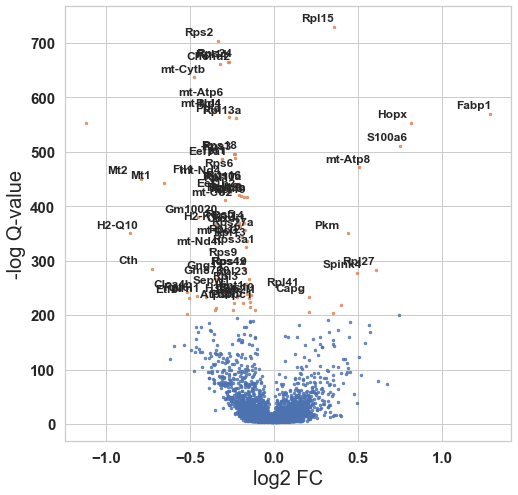

In [74]:
#Volcano plot of results
ent_de['-logQ'] = -np.log(ent_de['FDR'])
lowqval_de = ent_de.loc[ent_de['-logQ'] > 200]
other_de = ent_de.loc[ent_de['-logQ'] < 200]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 230 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [75]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

paneth_enrichment = gp.profile(organism='mmusculus', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=adata1.var_names.tolist(), 
                               query=ent_de['primerid'].tolist())

In [76]:

#paneth_enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
paneth_enrich_results = paneth_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [77]:
pd.set_option("display.max_colwidth", 800)
paneth_enrich_results.iloc[:50,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0008152,6.183771e-57,8723,2615,0.299782,metabolic process
GO:0044237,4.590556e-50,8145,2446,0.300307,cellular metabolic process
GO:0071704,2.752911e-47,8268,2464,0.298016,organic substance metabolic process
GO:0008150,3.901523e-47,13919,3731,0.268051,biological_process
GO:0009987,9.665936e-47,11422,3202,0.280336,cellular process
GO:0044238,3.135853e-43,7934,2363,0.297832,primary metabolic process
GO:1901564,1.690694e-34,5124,1604,0.313037,organonitrogen compound metabolic process
GO:0006807,3.910950e-33,7516,2211,0.294172,nitrogen compound metabolic process
GO:0044281,3.585015e-28,1457,552,0.378861,small molecule metabolic process


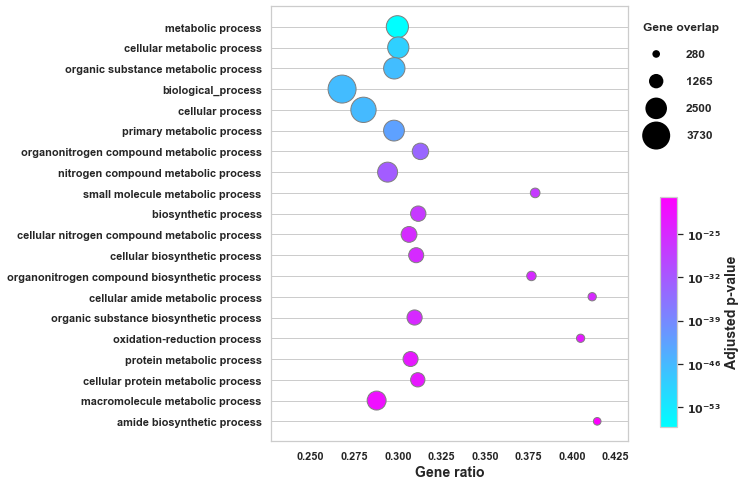

In [78]:
def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)
def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()
    

plot_enrich(paneth_enrich_results)